<a href="https://colab.research.google.com/github/victorsamsara/datascience/blob/master/4_1_movie_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study 4.1 - Movies

<h1 style="color:red;">Note: If you close this notebook at any time, you will have to run all cells again upon re-opening it.</h1>

<h1 style="color:red;">Note: You may get different numerical results running the notebook different times. This is to be expected, you can just report whatever results you get.</h1>

# ADVANCED PYTHON

As this is an advanced version, we don't include a lot of code here. If you get stuck on a particular part, feel free to also use the beginner version in `beginnner_python.ipynb` to help you out.

# Identification Information

You can find your MITxPro username on this [page](https://courses.xpro.mit.edu/courses/course-v1:xPRO+DSx+R14/progress) and copying the username in quotations after it says "Student". For example, Kevin's username is "kevin-lyons".

**Please use the correct username and the e-mail address right next to it as it makes it much easier for course staff to identify your notebook.**

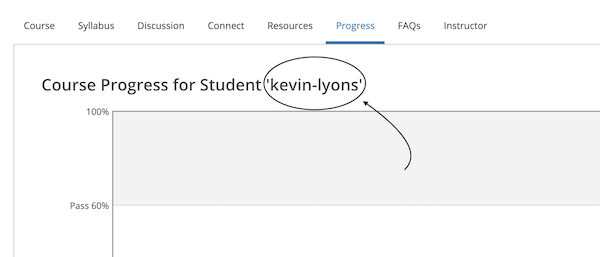

**YOUR NAME**              = Victor Nicolas Gonzalez Alcantara

**YOUR MITX PRO USERNAME** = victor-nicolas-gonzalez-alcant

**YOUR MITX PRO E-MAIL**   = victor@samsara.com

# Setup

Run these cells to install all the packages you need to complete the remainder of the case study. This may take a few minutes, so please be patient.

In [ ]:
!pip install --upgrade pip
!pip install surprise==0.1

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)


# Import

In [ ]:
import pandas as pd
import matplotlib
from surprise import Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold
print('import successful')

import successful


# Data

Use the [`**Dataset.load_builtin**`](http://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin) function to load the data.

In [ ]:
movieLensData = Dataset.load_builtin('ml-100k')
print('\n Upload Complete')


 Upload Complete


We also want to get a sense of what the data looks like. Please create a histogram of all the ratings we have in the dataset.

100000
mean = 3.52986
median = 4.0
std = 1.125673599144129


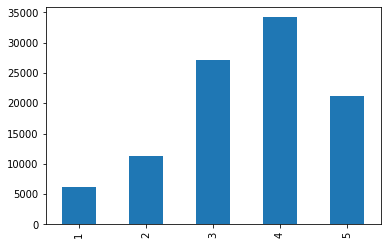

In [ ]:

ratingsFile = movieLensData.ratings_file

"""

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   
"""

columns = ['user id','item id','rating','timestamp']

data = pd.read_table(ratingsFile,names=columns)

ratings = data.rating

#count ratings -> 100K
print(len(ratings))

#plot histogram
table = ratings.value_counts()
table.sort_index().plot.bar()


#compute mean, median, std
print('mean = ' + str(ratings.mean()))
print('median = ' + str(ratings.median()))
print('std = ' + str(ratings.std()))







<h1 style="color:red;">QUESTION 1: DATA ANALYSIS</h1>

**Describe the dataset. How many ratings are in the dataset? How would you describe the distribution of ratings? Is there anything else we should observe? Make sure the histogram is visible in the notebook.**

There are 100,000 ratings in the dataset. At first glance, the distribution of ratings looks very similar to a discrete beta distribution. The majority of the ratings are 4, 3 and 5 respectively. A couple of extra observations, Mean is 3.53, Median is 4 and Std is 1.26. 

# Model 1: Random

In [ ]:
# Create model using NormalPredictor() class
modelRandom = NormalPredictor()

In [ ]:
# Train on data using cross-validation with k=5 folds, measuring the RMSE
# See the cross_validate function that we have imported above
# http://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.validation.cross_validate

"""

Run a cross validation procedure for a given algorithm, reporting accuracy measures and computation times.

See an example in the User Guide.

Parameters:	
algo (AlgoBase) – The algorithm to evaluate.
data (Dataset) – The dataset on which to evaluate the algorithm.
measures (list of string) – The performance measures to compute. Allowed names are function names as defined in the accuracy module. Default is ['rmse', 'mae'].
cv (cross-validation iterator, int or None) – Determines how the data parameter will be split (i.e. how trainsets and testsets will be defined). If an int is passed, KFold is used with the appropriate n_splits parameter. If None, KFold is used with n_splits=5.
return_train_measures (bool) – Whether to compute performance measures on the trainsets. Default is False.
n_jobs (int) –
The maximum number of folds evaluated in parallel.

If -1, all CPUs are used.
If 1 is given, no parallel computing code is used at all, which is useful for debugging.
For n_jobs below -1, (n_cpus + n_jobs + 1) are used. For example, with n_jobs = -2 all CPUs but one are used.
Default is 1.

pre_dispatch (int or string) –
Controls the number of jobs that get dispatched during parallel execution. Reducing this number can be useful to avoid an explosion of memory consumption when more jobs get dispatched than CPUs can process. This parameter can be:

None, in which case all the jobs are immediately created and spawned. Use this for lightweight and fast-running jobs, to avoid delays due to on-demand spawning of the jobs.
An int, giving the exact number of total jobs that are spawned.
A string, giving an expression as a function of n_jobs, as in '2*n_jobs'.
Default is '2*n_jobs'.

verbose (int) – If True accuracy measures for each split are printed, as well as train and test times. Averages and standard deviations over all splits are also reported. Default is False: nothing is printed.

"""
crossValidationRandom = cross_validate(modelRandom,movieLensData,cv=5,measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5318  1.5222  1.5160  1.5067  1.5205  1.5195  0.0082  
Fit time          0.14    0.16    0.17    0.16    0.17    0.16    0.01    
Test time         0.26    0.14    0.24    0.14    0.23    0.20    0.05    


# Model 2: User-Based Collaborative Filtering

In [ ]:
# Create model using KNNBasic() class
# See the sim_options parameter to determine the user/item similarity calculation of the model
# http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration

"""
 Many algorithms use a similarity measure to estimate a rating. The way they can be configured is done in a similar fashion as for baseline ratings: you just need to pass a sim_options argument at the creation of an algorithm. This argument is a dictionary with the following (all optional) keys:

'name': The name of the similarity to use, as defined in the similarities module. Default is 'MSD'.
'user_based': Whether similarities will be computed between users or between items. This has a huge impact on the performance of a prediction algorithm. Default is True.
'min_support': The minimum number of common items (when 'user_based' is 'True') or minimum number of common users (when 'user_based' is 'False') for the similarity not to be zero. Simply put, if |𝐼𝑢𝑣|<min_support then sim(𝑢,𝑣)=0. The same goes for items.
'shrinkage': Shrinkage parameter to apply (only relevant for pearson_baseline similarity). Default is 100.

"""
modelUser = KNNBasic()

In [ ]:
# Train using same cross validation code as above

crossValidationUser = cross_validate(modelUser,movieLensData,cv=5,measures=['RMSE'], verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9736  0.9746  0.9935  0.9851  0.9700  0.9794  0.0087  
Fit time          0.42    0.43    0.42    0.40    0.43    0.42    0.01    
Test time         3.75    3.82    3.81    3.82    3.79    3.80    0.02    


# Model 3: Item-Based Collaborative Filtering

In [ ]:
# Create model using KNNBasic() class
# Make sure you change the sim_options parameter from above
modelItem = KNNBasic(sim_options={'user_based':False})

In [ ]:
# Train using same cross validation code as above
crossValidationItem = cross_validate(modelItem,movieLensData,cv=5,measures=['RMSE'], verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9727  0.9798  0.9731  0.9722  0.9711  0.9738  0.0031  
Fit time          0.63    0.66    0.68    0.64    0.63    0.65    0.02    
Test time         4.42    4.48    4.57    4.51    4.52    4.50    0.05    


<h1 style="color:red;">QUESTION 2: COLLABORATIVE FILTERING MODELS</h1>

**Compare the results from the user-user and item-item models. How do they compare to each other? How do they compare to our original "random" model? Can you provide any intuition as to why the results came out the way they did?**

The results between the user-user and item-item models are fairly similar (mean of ~0.97 RMSE each), which is an improvement from the random model (mean of ~1.52) as expected. We can start to notice patterns in the user and item models. Probably the main reason the RMSEs are fairly similar is that in the movie ratings scenario types of users tend to rate movies very similary, and an item (or movie) that was rated highly/lowly implies that another movie of the similar genre will be rated highly/lowly as well. It's effective to find patterns either from the user perspective or from the items alone. For example, if user A and user B both are into adventure movies they will rate adventure movies highly. If an adventure movie is rated highly, this might imply than an adjacent movie genre might also be rated highly as well. 

# Model 4: Matrix Factorization

In [ ]:
# Create model using SVD() class
modelMatrix = SVD()

In [ ]:
# Train using same cross validation code as above
crossValidationMatrix = cross_validate(modelMatrix,movieLensData,cv=5,measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9391  0.9370  0.9377  0.9329  0.9350  0.9363  0.0022  
Fit time          5.33    5.36    5.46    5.30    5.57    5.40    0.10    
Test time         0.16    0.28    0.16    0.26    0.20    0.21    0.05    


<h1 style="color:red;">QUESTION 3: MATRIX FACTORIZATION MODEL</h1>

**The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE again. Does it improve? Can you offer any reasoning as to why that might be?**

The RMSE definitely improves from ~0.97 to ~0.94. Singular Value Decomposition is a principal component analysis technique that finds patterns in the data set. In the case of user and ratings, SVD will find associations of both user and ratings for each patterns which leads to a better prediction (lower RMSE). 

# Precision and Recall @ `k`

We now want to compute the precision and recall for 2 values of `k`: 5 and 10. We have provided some code here to help you do that.

First, we define a function that takes in some predictions, a value of `k` and a threshold parameter. This code is adapted from [here](http://surprise.readthedocs.io/en/stable/FAQ.html?highlight=precision#how-to-compute-precision-k-and-recall-k).

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, list())
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

Next, we compute the precision and recall at `k` = 5 and 10 for each of our 4 models. We use 5-fold cross validation again to average the results across the entire dataseat.

Please note that this will take some time to compute.

<h1 style="color:red;">QUESTION 4: PRECISION/RECALL</h1>

**Compute the precision and recall, for each of the 4 models, at `k` = 5 and 10. This is 2 x 2 x 4 = 16 numerical values. Do you note anything interesting about these values? Anything differerent from the RMSE values you computed above?**

Some code is required for this question.

In [ ]:
# Use the function above to compute the 16 numerical values requested above
# See the test() function to get the predictions input to the function
# http://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.test


modelsList = [modelRandom, modelUser, modelItem, modelMatrix]

# Create k-fold cross validation object
kF = KFold(n_splits=5)

for k in [5,10]:
    for model in modelsList:
        print(f'>>> k={k}, model={model.__class__.__name__}')
        p = []
        r = []
        for trainset, testset in kF.split(movieLensData):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('>>> precision:', round(sum(p) / len(p), 3))
        print('>>> reccall  :', round(sum(r) / len(r), 3))
        print('\n')


>>> k=5, model=NormalPredictor
>>> precision: 0.585
>>> reccall  : 0.342


>>> k=5, model=KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precision: 0.763
>>> reccall  : 0.456


>>> k=5, model=KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precision: 0.814
>>> reccall  : 0.389


>>> k=5, model=SVD
>>> precision: 0.782
>>> reccall  : 0.43

k=5, model=NormalPredictor (Random)
precision: 0.585
reccall  : 0.342

k=5, model=KNNBasic (User)
precision: 0.763
reccall  : 0.456

k=5, model=KNNBasic (Item)
precision: 0.814
reccall  : 0.389

k=5, model=SVD
precision: 0.782
reccall  : 0.432

k=10, model=NormalPredictor (Random)
precision: 0.587
reccall  : 0.434

k=10, model=KNNBasic (User)
precision: 0.738
reccall  : 0.593

k=10, model=KNNBasic (Item)
precision: 0.79
reccall  : 0.536

k=10, model=SVD
precision: 0.756
reccall  : 0.563

The most precise model is the Items-based. The lowest recall model is the Random. The best (lowest) RMSE is the SVD. This result is very interesting. Basically the way to interpret this is that the Items-based model will predict the right recommendation more accurately, however, when the prediction is wrong actually the recommendation error will be larger than with the SVD model.  

#  Top-`n` Predictions

Finally, we can see what some of the actual movie ratings are for particular users, as outputs of our model.

Again, we define a helpful function.

In [ ]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Then, we call this function on each of our models, first training on **all** the data we have available, then predicting on the remaining, missing data. We use `n`=5 here, but you can pick any reasonable value of `n` you would like.

This may take some time to compute, so be patient.

Hint: Use [`**Dataset.build_full_trainset**`](http://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.DatasetAutoFolds.build_full_trainset) to get the full trainset from the data. Then call [`**Trainset.build_anti_testset**`](http://surprise.readthedocs.io/en/stable/trainset.html#surprise.Trainset.build_anti_testset) to get the testset out. Finally, `fit` on the trainset, `test` on the testset, then pass that result to our `get_top_n` function.

<h1 style="color:red;">QUESTION 5: TOP N PREDICTIONS</h1>

**Do the top n predictions that you received make sense? What is the rating value (1-5) of these predictions? How could you use these predictions in the real-world if you were trying to build a generic content recommender system for a company?**

Some code is required for this question.

In [ ]:
# Use the function and hints above to give the top-n predictions for a given user, for a reasonable value of n

modelNames = ['modelRandom', 'modelUser', 'modelItem', 'modelMatrix']

for i, model in enumerate(modelsList):
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)

    # Print first user

    user = list(top_n.keys())[0]
    print(f'model name: {modelNames[i]}')
    print(f'user ID: {user}')
    print(f'top 5 movie ID\'s this user would like, sorted by rating highest to lowest: {top_n[user]}')


model name: modelRandom
user ID: 156
top 5 movie ID's this user would like, sorted by rating highest to lowest: [('346', 3.821265700446441), ('22', 3.2352692826180225), ('806', 2.8994889994066133), ('357', 2.472907492945658), ('83', 1.7106305809634674)]
Computing the msd similarity matrix...
Done computing similarity matrix.
model name: modelUser
user ID: 156
top 5 movie ID's this user would like, sorted by rating highest to lowest: [('357', 4.2447355917857825), ('83', 4.1108848373577676), ('22', 4.042955588253901), ('346', 3.760495576991355), ('806', 3.5259080736503865)]
Computing the msd similarity matrix...
Done computing similarity matrix.
model name: modelItem
user ID: 156
top 5 movie ID's this user would like, sorted by rating highest to lowest: [('346', 3.8959812346974476), ('357', 3.875498051633564), ('83', 3.842546992346988), ('806', 3.825924321086907), ('22', 3.8159166927057884)]
model name: modelMatrix
user ID: 156
top 5 movie ID's this user would like, sorted by rating high

It does make sense since the top 5 movie-ID predictions for each of the models are the same for user-ID 156, which consist of the following movie-IDs: 33,246,806,83 and 357. Regardless of the rating assigned, which varies per model, we can come up with a list of "Recommended for You" movies for user-ID 156. The rating value of these predictions range from 1.71 (lowest rating given by the Random Model) to 4.24 (highest rating given by User-User model). The way I would use these predictions is by first defining a "recommendation" threshold, say the user's mean/average of ratings up to that point or some arbitatry threhsold like 3.8. If a predicted rating for a movie is > 3.8 (or above the threshold defined), then I would list it as "Recommended for You".

<hr>

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.xpro.mit.edu/asset-v1:xPRO+DSx+R14+type@asset+block/4.1_instruction_manual_14.html) to wrap up this case study properly.